<a href="https://colab.research.google.com/github/ipez02/cs166project/blob/main/cs166project_base_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test 3 --- Final Test for 06.11.2025

In [30]:
!pip install gymnasium[atari,accept-rom-license]
!pip install autorom
!pip install stable-baselines3

In [31]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


# Install the Gym

In [32]:
import ale_py
import gymnasium as gym

# Configure the model save drive

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import os
save_dir = "/content/drive/MyDrive/PUBLIC/Models"
os.makedirs(save_dir, exist_ok=True)

# Now Model

In [35]:
from dataclasses import dataclass
import argparse
import time
from datetime import datetime
import numpy as np
import collections
import typing as tt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard.writer import SummaryWriter

In [36]:
#dqn_model
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        size = self.conv(torch.zeros(1, *input_shape)).size()[-1]
        self.fc = nn.Sequential(
            nn.Linear(size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, x: torch.ByteTensor):
        x = x.float() / 255.0
        return self.fc(self.conv(x))

In [37]:
#wrappers

from gymnasium import spaces
from stable_baselines3.common import atari_wrappers


class ImageToPyTorch(gym.ObservationWrapper):
    """
    ImageToPyTorch: Reorders image dimensions from (H, W, C) to (C, H, W)
    for compatibility with PyTorch convolutional layers.
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        obs = self.observation_space
        assert isinstance(obs, gym.spaces.Box)
        assert len(obs.shape) == 3
        new_shape = (obs.shape[-1], obs.shape[0], obs.shape[1])
        self.observation_space = gym.spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=new_shape, dtype=obs.dtype)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    """
    BufferWrapper: Maintains a rolling window of the last `n_steps` frames
    to give the agent a sense of temporal context.
    """
    def __init__(self, env, n_steps):
        super(BufferWrapper, self).__init__(env)
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        new_obs = gym.spaces.Box(
            obs.low.repeat(n_steps, axis=0), obs.high.repeat(n_steps, axis=0),
            dtype=obs.dtype)
        self.observation_space = new_obs
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict[str, tt.Any]] = None):
        for _ in range(self.buffer.maxlen):
            self.buffer.append(np.zeros_like(self.env.observation_space.low))
        obs, extra = self.env.reset()
        return self.observation(obs), extra

    def observation(self, observation: np.ndarray) -> np.ndarray:
        self.buffer.append(observation)
        return np.concatenate(self.buffer)


def make_env(env_name: str, n_steps=4, render_mode=None, **kwargs):
    print(f"Creating environment {env_name}")
    env = gym.make(env_name, render_mode=render_mode, **kwargs)
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=n_steps)
    return env

# Environment Description: Pong (ALE/Pong-v5)

For this project we use **Atari Pong** via `gymnasium`:

- **Observation space**: processed grayscale image stack.
  - Each observation is an image of size 84×84 (after preprocessing and down-sampling),
  - We stack the last `n_steps` frames along the channel dimension (default `n_steps=4`),
  - So `env.observation_space.shape = (4, 84, 84)` for our DQN.
- **Action space**: discrete set of joystick actions.
  - Pong has a small discrete action space, and the wrapper restricts to the minimal useful subset,
  - e.g. `NOOP`, `UP`, `DOWN` → `env.action_space.n` is typically 3 or 4.
- **Reward signal**:
  - Rewards are **+1** when our paddle scores a point,
  - **-1** when the opponent scores,
  - 0 otherwise, so rewards are **sparse** and only appear when a point is scored.
  - Episodes end at a fixed winning score (e.g., game over at ±21 points).

This setup matches the classic DQN Atari Pong benchmark and is friendly to a conv-net DQN.

In [38]:
# Base Configuration (project + Colab friendly)
DEFAULT_ENV_NAME = "ALE/Pong-v5"   # Atari Pong environment
MEAN_REWARD_BOUND = 19             # Considered "solved" threshold for full runs

# Core DQN hyperparameters
GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10_000               # bounded replay size to avoid RAM blow-up
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1_000
REPLAY_START_SIZE = 10_000

# Saving / exploration schedule
SAVE_EPSILON = 0.5  # Only save if at least this much better
EPSILON_DECAY_LAST_FRAME = 150_000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01

# DQN variant toggle (for second run / extension)
#   False -> vanilla DQN (baseline)
#   True  -> Double DQN target computation (extension)
USE_DOUBLE_DQN = False

# Tuple of tensors returned from a sampled minibatch in replay buffer
State = np.ndarray
Action = int
BatchTensors = tt.Tuple[
    torch.ByteTensor,           # current state
    torch.LongTensor,           # actions
    torch.Tensor,               # rewards
    torch.BoolTensor,           # done || trunc
    torch.ByteTensor            # next state
]


In [39]:
# ⚙️ Fast Training Config for Quick Colab Test Runs
# Run this cell AFTER the base configuration to override some settings
# for shorter, more debug-friendly runs.

MEAN_REWARD_BOUND = 5          # stop when Pong clearly improves
REPLAY_START_SIZE = 1_000      # start learning earlier
EPSILON_DECAY_LAST_FRAME = 10_000
SYNC_TARGET_FRAMES = 500

# Optional: uncomment to shrink memory usage even more
REPLAY_SIZE = 5_000
BATCH_SIZE = 16

# Optional: turn on Double DQN for your "extension" run
USE_DOUBLE_DQN = False

In [40]:
import os
from pathlib import Path

# Define directories
save_dir_drive = "/content/drive/MyDrive/PUBLIC/Models"
save_dir_local = "saved_models"

# Create both directories if they don't exist
os.makedirs(save_dir_drive, exist_ok=True)
os.makedirs(save_dir_local, exist_ok=True)

# Safe model filename
env_name = DEFAULT_ENV_NAME
safe_env_name = env_name.replace("/", "_")

In [41]:
@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done_trunc: bool
    new_state: State


class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> tt.List[Experience]:
        indices = np.random.choice(len(self), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]

In [42]:
class Agent:
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.state: tt.Optional[np.ndarray] = None
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device,
                  epsilon: float = 0.0) -> tt.Optional[float]:
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_v = torch.as_tensor(self.state).to(device)
            state_v.unsqueeze_(0)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, is_tr, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(
            state=self.state, action=action, reward=float(reward),
            done_trunc=is_done or is_tr, new_state=new_state
        )
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done or is_tr:
            done_reward = self.total_reward
            self._reset()
        return done_reward

In [43]:
def batch_to_tensors(batch: tt.List[Experience], device: torch.device) -> BatchTensors:
    states, actions, rewards, dones, new_state = [], [], [], [], []
    for e in batch:
        states.append(e.state)
        actions.append(e.action)
        rewards.append(e.reward)
        dones.append(e.done_trunc)
        new_state.append(e.new_state)
    states_t = torch.as_tensor(np.asarray(states))
    actions_t = torch.LongTensor(actions)
    rewards_t = torch.FloatTensor(rewards)
    dones_t = torch.BoolTensor(dones)
    new_states_t = torch.as_tensor(np.asarray(new_state))
    return states_t.to(device), actions_t.to(device), rewards_t.to(device), \
           dones_t.to(device),  new_states_t.to(device)

In [44]:
def calc_loss(batch: tt.List[Experience], net: DQN, tgt_net: DQN,
              device: torch.device) -> torch.Tensor:
    """Compute Bellman loss.

    If USE_DOUBLE_DQN is True, use Double DQN target computation:
        a* = argmax_a Q_online(s', a)
        y  = r + γ Q_target(s', a*)
    Otherwise, fall back to standard DQN target:
        y  = r + γ max_a Q_target(s', a)
    """
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    # Q(s, a) for actions taken
    state_action_values = net(states_t).gather(
        1, actions_t.unsqueeze(-1)
    ).squeeze(-1)

    with torch.no_grad():
        if USE_DOUBLE_DQN:
            # Double DQN: action selection from online net, evaluation from target net
            online_q_next = net(new_states_t)
            next_actions = online_q_next.argmax(dim=1)
            target_q_next = tgt_net(new_states_t)
            next_state_values = target_q_next.gather(
                1, next_actions.unsqueeze(-1)
            ).squeeze(-1)
        else:
            # Vanilla DQN target: max over actions from target network
            next_state_values = tgt_net(new_states_t).max(1)[0]

        # Zero-out bootstrap term for terminal states
        next_state_values[dones_t] = 0.0

    expected_state_action_values = rewards_t + GAMMA * next_state_values
    return nn.MSELoss()(state_action_values, expected_state_action_values)


In [45]:
# Main training loop (Colab friendly)
# Set an explicit safety cap on total frames to avoid very long runs.
MAX_FRAMES = 500_000  # adjust up/down as needed for your project

model_comment = f"test_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_sync{SYNC_TARGET_FRAMES}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_env(env_name)
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

start_time = time.time()
while frame_idx < MAX_FRAMES:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        elapsed = time.time() - start_time  # in seconds
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        #  print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
        #      f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)
        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, "
                f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            # Save to both paths
            model_path_drive = os.path.join(save_dir_drive, model_filename)
            model_path_local = os.path.join(save_dir_local, model_filename)

            torch.save(net.state_dict(), model_path_drive)
            torch.save(net.state_dict(), model_path_local)

            print(f"💾 Model saved to:\n - Google Drive: {model_path_drive}\n - Local:        {model_path_local}")
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward
        if m_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            break
    if len(buffer) < REPLAY_START_SIZE:
        continue
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()
env.close()
writer.close()

Creating environment ALE/Pong-v5
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
204: done 1 games, reward -21.000, eps 0.98, speed 147.20 f/s, time 0.0 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-21-20251128-0811-test_epsdec10000_rs1000_sync500.dat
 - Local:        saved_models/ALE_Pong-v5-best_-21-20251128-0811-test_epsdec10000_rs1000_sync500.dat
650: done 3 games, reward -20.333, eps 0.94, speed 144.37 f/s, time 0.1 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_Pong-v5-best_-20-20251128-0811-te

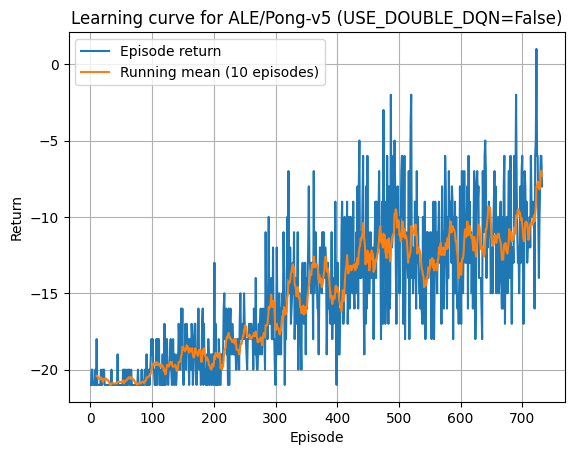

In [46]:
# 📈 Plot learning curve: episodic return vs. training episodes
import matplotlib.pyplot as plt
import numpy as np

if len(total_rewards) == 0:
    print("No rewards logged yet. Run the training cell first.")
else:
    episodes = np.arange(1, len(total_rewards) + 1)
    plt.figure()
    plt.plot(episodes, total_rewards, label="Episode return")
    if len(total_rewards) >= 10:
        window = 10
        running_mean = np.convolve(total_rewards, np.ones(window)/window, mode="valid")
        plt.plot(np.arange(window, len(total_rewards)+1), running_mean,
                 label=f"Running mean ({window} episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title(f"Learning curve for {env_name} (USE_DOUBLE_DQN={USE_DOUBLE_DQN})")
    plt.legend()
    plt.grid(True)
    plt.show()


In [47]:
# 🎥 Helper: record a short video of the agent (early or trained)

import os
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import RecordVideo

video_dir = "videos"
os.makedirs(video_dir, exist_ok=True)

def record_episode(policy_net, env_name: str, max_steps: int = 5_000,
                   epsilon: float = 0.0, name_prefix: str = "pong_video"):
    """Record a single episode to MP4 in the videos/ folder.

    Args:
        policy_net: DQN network (or None for random policy).
        env_name: e.g. "ALE/Pong-v5"
        max_steps: safety cap on episode length.
        epsilon: exploration epsilon (0.0 = greedy).
        name_prefix: filename prefix, e.g. "pong_early" or "pong_learned".
    """
    env = make_env(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_folder=video_dir,
                      name_prefix=name_prefix,
                      episode_trigger=lambda eid: True)
    state, _ = env.reset()
    total_reward = 0.0

    step = 0
    while True:
        step += 1
        if policy_net is None or np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_v = torch.as_tensor(state, dtype=torch.uint8).unsqueeze(0).to(device)
                q_vals = policy_net(state_v)
                action = int(q_vals.argmax(dim=1).item())

        state, reward, done, trunc, _ = env.step(action)
        total_reward += reward
        if done or trunc or step >= max_steps:
            break

    env.close()
    print(f"Recorded episode '{name_prefix}' with return {total_reward:.1f}")
    print(f"Check the '{video_dir}' directory and copy the MP4 into your repo.")
